In [1]:
import pandas as pd
import pyproj
import ee
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/opt/anaconda3/envs/final_project/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.18) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
population_df = pd.read_csv('population.csv', index_col=0)

In [3]:
in_crs = pyproj.CRS("EPSG:3857")

out_crs = pyproj.CRS("EPSG:4326")

transformer = pyproj.Transformer.from_crs(in_crs, out_crs, always_xy=True)

lon_series, lat_series = transformer.transform(
    xx=population_df['longitude'].values,
    yy=population_df['latitude'].values,
)

population_df['LONG'] = lon_series

population_df['LAT'] = lat_series

print("DataFrame conversion optimized and completed.")

print(population_df[['LONG', 'LAT']].head())

DataFrame conversion optimized and completed.
        LONG        LAT
0 -68.566853 -32.658667
1 -68.537095 -32.666286
2 -67.925100 -32.110468
3 -68.199518 -32.142502
4 -68.193925 -32.148056


In [4]:
#ee.Authenticate()

In [5]:
ee.Initialize(project='ee-jonesd6000')

In [6]:
ERA5_LAND_MONTHLY_AGGR = 'ECMWF/ERA5_LAND/MONTHLY_AGGR'

start_date = '2024-01-01'

end_date = '2025-01-01'

variable_name = 'temperature_2m' # Temperature at 2 meters above ground (in Kelvin)

scale = 11132 # Resolution in meters (~9 km for ERA5-Land)

# Function to sample the value and attach time property within GEE environment
def sample_image(image):
    """Samples the image at the defined point and adds the result as a property."""
    value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point, # Use the global 'point' defined earlier
        scale=scale
    )
    
    # Return the image with a new property containing the sampled value
    return image.set('value', value.get(variable_name))

irradiance = []

for i, row in population_df.sample(100).iterrows():
    point = ee.Geometry.Point(row['LONG'], row['LAT'])

    # Load the Image Collection, filter by date and bounds, and select the band
    era5_collection = ee.ImageCollection(ERA5_LAND_MONTHLY_AGGR) \
    .filterDate(start_date, end_date) \
    .filterBounds(point) \
    .select(variable_name)

    # Map the sampling function over the collection (server-side operation)
    collection_with_values = era5_collection.map(sample_image)

    # Get the list of results (client-side operation using getInfo())
    # We extract the properties we need: system:time_start and the 'value' we set
    data = collection_with_values.reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=['system:time_start', 'value']
    ).getInfo()['list']

    # Convert the results to a Pandas DataFrame
    df = pd.DataFrame(data, columns=['Time (ms)', 'Temperature (K)'])

    # Process the DataFrame to clean up types and add Celsius
    df['Time'] = pd.to_datetime(df['Time (ms)'], unit='ms')
    df['Temperature (C)'] = df['Temperature (K)'] - 273.15

    # Reorder and print the DataFrame
    df = df[['Time', 'Temperature (K)', 'Temperature (C)']]
    
    df['LONG'] = row['LONG']
    
    df['LAT'] = row['LAT']
    
    irradiance.append(df)

In [7]:
irradiance_df = pd.concat(irradiance)

print(irradiance_df)

         Time  Temperature (K)  Temperature (C)       LONG        LAT
0  2024-01-01       273.665164         0.515164 -96.084562  36.077890
1  2024-02-01       283.274508        10.124508 -96.084562  36.077890
2  2024-03-01       286.539545        13.389545 -96.084562  36.077890
3  2024-04-01       290.606561        17.456561 -96.084562  36.077890
4  2024-05-01       295.344147        22.194147 -96.084562  36.077890
..        ...              ...              ...        ...        ...
7  2024-08-01       303.563500        30.413500  38.111192  36.107808
8  2024-09-01       300.311645        27.161645  38.111192  36.107808
9  2024-10-01       294.852939        21.702939  38.111192  36.107808
10 2024-11-01       287.593872        14.443872  38.111192  36.107808
11 2024-12-01       282.847041         9.697041  38.111192  36.107808

[1164 rows x 5 columns]


/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_34466/1820602084.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  irradiance_df = pd.concat(irradiance)


In [8]:
irradiance_df_agg = irradiance_df.groupby(['LONG','LAT']).mean(1)

print(irradiance_df_agg)

                       Temperature (K)  Temperature (C)
LONG        LAT                                        
-119.444022 50.053778       281.868549         8.718549
-104.382291 20.574326       293.886412        20.736412
-102.642109 21.884141       291.847340        18.697340
-101.377713 36.586109       289.591641        16.441641
-101.200901 35.611506       289.975936        16.825936
...                                ...              ...
 121.602665 17.310634       298.406782        25.256782
 126.473828 48.301308       276.192842         3.042842
 127.378159 49.757002       275.842837         2.692837
 134.832441 34.397552       290.094239        16.944239
 141.214801 38.417460       287.187821        14.037821

[97 rows x 2 columns]


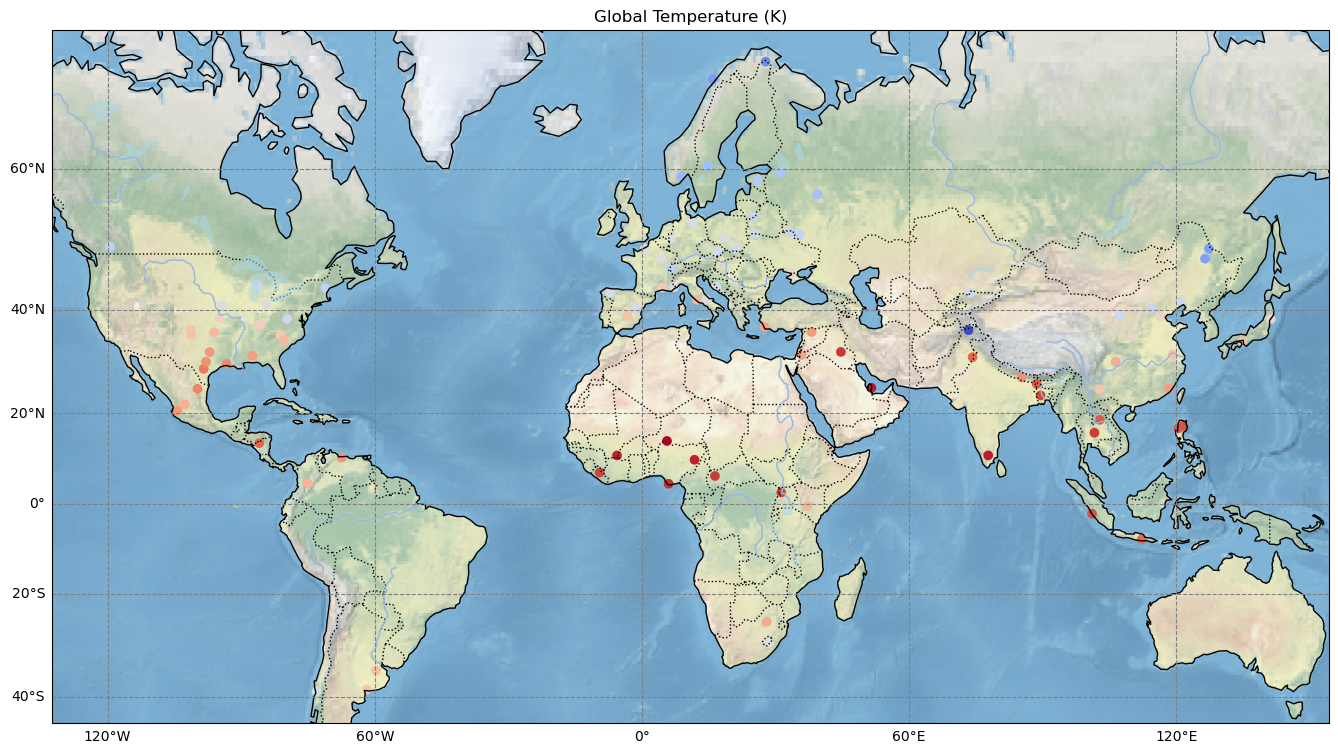

In [9]:
fig = plt.figure(figsize=(20,9))

_map = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

_map.add_feature(cfeature.LAND, color='lightgray')
_map.add_feature(cfeature.OCEAN, color='lightblue')
_map.add_feature(cfeature.COASTLINE)
_map.add_feature(cfeature.BORDERS, linestyle=':')
_map.add_feature(cfeature.LAKES, alpha=0.5, color='lightblue')
_map.add_feature(cfeature.RIVERS)

_map.scatter(irradiance_df_agg.index.get_level_values('LONG'),
             irradiance_df_agg.index.get_level_values('LAT'),
             c=irradiance_df_agg['Temperature (K)'],
             cmap='coolwarm',
             transform=ccrs.PlateCarree())

gl = _map.gridlines(draw_labels=True,
                    dms=True,
                    x_inline=False,
                    y_inline=False,
                    color='gray',
                    linestyle='--')

_map.stock_img()

gl.top_labels = False

gl.right_labels = False

_map.set_title('Global Temperature (K)')

plt.show()

<h3>AI Generated Code</h3>

In [23]:
# =============================================================================
# Code generated by Artificial Intelligence (Google Gemini)
# Date: 2025-12-02
# Prompt: "Python function to calculate irradiance at certain latitude and
#         longitude using earthengine-api"
# Disclaimer: This code was reviewed and verified by a human developer. 
# =============================================================================

import ee
import pandas as pd

# Initialize the Earth Engine API
# ee.Authenticate() # Run this line if you haven't authenticated in your environment
ee.Initialize()

# Define a location (e.g., a point near Richmond, VA, USA)
lon = -77.4
lat = 37.5
point = ee.Geometry.Point(lon, lat)

# Define the dataset ID, dates, and variable of interest
ERA5_LAND_HOURLY = 'ECMWF/ERA5_LAND/HOURLY'
start_date = '2024-01-01'
end_date = '2024-01-02'
variable_name = 'temperature_2m' # Temperature at 2 meters above ground (in Kelvin)
scale = 11132 # Resolution in meters (~9 km for ERA5-Land)

# Load the Image Collection, filter by date and bounds, and select the band
era5_collection = ee.ImageCollection(ERA5_LAND_HOURLY) \
    .filterDate(start_date, end_date) \
    .filterBounds(point) \
    .select(variable_name)

# Function to sample the value and attach time property within GEE environment
def sample_image(image):
    """Samples the image at the defined point and adds the result as a property."""
    value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point, # Use the global 'point' defined earlier
        scale=scale
    )
    # Return the image with a new property containing the sampled value
    return image.set('value', value.get(variable_name))

# Map the sampling function over the collection (server-side operation)
collection_with_values = era5_collection.map(sample_image)

# Get the list of results (client-side operation using getInfo())
# We extract the properties we need: system:time_start and the 'value' we set
data = collection_with_values.reduceColumns(
    reducer=ee.Reducer.toList(2),
    selectors=['system:time_start', 'value']
).getInfo()['list']

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(data, columns=['Time (ms)', 'Temperature (K)'])

# Process the DataFrame to clean up types and add Celsius
df['Time'] = pd.to_datetime(df['Time (ms)'], unit='ms')
df['Temperature (C)'] = df['Temperature (K)'] - 273.15

# Reorder and print the DataFrame
df = df[['Time', 'Temperature (K)', 'Temperature (C)']]
print(df)


                  Time  Temperature (K)  Temperature (C)
0  2024-01-01 00:00:00       278.542633         5.392633
1  2024-01-01 01:00:00       277.868652         4.718652
2  2024-01-01 02:00:00       277.415039         4.265039
3  2024-01-01 03:00:00       277.090683         3.940683
4  2024-01-01 04:00:00       276.815536         3.665536
5  2024-01-01 05:00:00       276.594543         3.444543
6  2024-01-01 06:00:00       276.575211         3.425211
7  2024-01-01 07:00:00       276.283325         3.133325
8  2024-01-01 08:00:00       276.059769         2.909769
9  2024-01-01 09:00:00       275.992844         2.842844
10 2024-01-01 10:00:00       275.797043         2.647043
11 2024-01-01 11:00:00       275.684418         2.534418
12 2024-01-01 12:00:00       275.633865         2.483865
13 2024-01-01 13:00:00       276.155792         3.005792
14 2024-01-01 14:00:00       278.097260         4.947260
15 2024-01-01 15:00:00       279.927750         6.777750
16 2024-01-01 16:00:00       28

In [ ]:
# =============================================================================
# Code generated by Artificial Intelligence (Google Gemini)
# Date: 2025-12-01
# Prompt: "Python function to calculate irradiance at certain latitude and
#         longitude using pvlib"
# Disclaimer: This code was reviewed and verified by a human developer. 
# It uses the WGS84 ellipsoid model for distance calculations via pyproj.
# =============================================================================

import pandas as pd
import pvlib
from pvlib.location import Location

# 1. Define your location and time
latitude = 34.05  # Example: Los Angeles
longitude = -118.24
altitude = 75     # Altitude in meters (optional, defaults to 0)
timezone = 'America/Los_Angeles'

site = Location(latitude, longitude, tz=timezone, altitude=altitude)

# Define the date and time range you want to check (e.g., hourly data for Jan 1st, 2025)
times = pd.date_range(start='2025-01-01', end='2025-01-02', freq='H', tz=timezone)

# 2. Calculate the clear-sky irradiance
# The get_clearsky method uses default clear-sky models (like Ineichen)
clearsky_data = site.get_clearsky(times)

# The output DataFrame includes:
# GHI (Global Horizontal Irradiance in W/m^2)
# DNI (Direct Normal Irradiance in W/m^2)
# DHI (Diffuse Horizontal Irradiance in W/m^2)

print("Clear sky GHI (Global Horizontal Irradiance) at noon (W/m^2):")
# Filter for a specific time (adjust the timestamp as necessary for your timezone)
print(clearsky_data.loc['2025-01-01 12:00:00-08:00', 'ghi'])

# Print the full day's data
# print(clearsky_data[['ghi', 'dni', 'dhi']])

In [ ]:
# =============================================================================
# Code generated by Artificial Intelligence (Google Gemini)
# Date: 2025-12-01
# Prompt: "Python function to calculate irradiance at certain latitude and
#         longitude using pvlib and pyproj"
# Disclaimer: This code was reviewed and verified by a human developer. 
# It uses the WGS84 ellipsoid model for distance calculations via pyproj.
# =============================================================================

import pyproj

# The input coordinates you provided
x_coordinate = -7632827
y_coordinate = -3850085

# Define the input projection system (Assumed: Web Mercator - EPSG 3857)
# and the output system (WGS84 Latitude/Longitude - EPSG 4326)
in_crs = pyproj.CRS("EPSG:3857")
out_crs = pyproj.CRS("EPSG:4326")

# Create a transformer object
transformer = pyproj.Transformer.from_crs(in_crs, out_crs, always_xy=True)

# Perform the transformation
lon, lat = transformer.transform(x_coordinate, y_coordinate)

print(f"Original X: {x_coordinate}, Original Y: {y_coordinate}")
print(f"Converted Latitude: {lat:.6f}")
print(f"Converted Longitude: {lon:.6f}")


In [ ]:
# =============================================================================
# Code generated by Artificial Intelligence (Google Gemini)
# Date: 2025-12-02
# Prompt: "The lambda function given takes too long, provide an optimization."
# Disclaimer: This code was reviewed and verified by a human developer. 
# =============================================================================

import pandas as pd
import pyproj

# Assume population_df is already loaded
# population_df = pd.read_csv('population.csv', index_col=0)

# --- Optimized Conversion ---

# 1. Define the input and output CRS objects just once
in_crs = pyproj.CRS("EPSG:3857")
out_crs = pyproj.CRS("EPSG:4326")

# 2. Create the transformer once
transformer = pyproj.Transformer.from_crs(in_crs, out_crs, always_xy=True)

# 3. Vectorize the transformation: Pass the entire columns (as arrays) to transform()
# This processes all data in C/Cython speed rather than Python speed.

lon_series, lat_series = transformer.transform(
    xx=population_df['longitude'].values,  # Pass the NumPy array of X coordinates
    yy=population_df['latitude'].values,   # Pass the NumPy array of Y coordinates
)

# 4. Assign the results back to the DataFrame
population_df['LONG'] = lon_series
population_df['LAT'] = lat_series

print("DataFrame conversion optimized and completed.")
print(population_df[['LONG', 'LAT']].head())
